<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/JR_Depth_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depth Perception Portion of JR Project

First, I load all of the found categories that YOLOv5 has detected and then I'm going to do depth perception on all of the objects. Only the two closest to the user will have haptic feedback.

## 1. Load in YOLOv5

### 1a. Get Google Drive in order to get the YOLOv5 checkpoint file

In [1]:
from google.colab import drive
drive.mount("./content/")

Mounted at ./content/


Check the checkpoint file exists.

In [2]:
from os.path import exists

checkpoint_file = "/content/content/MyDrive/Colab Notebooks/best.pt"
print("Does the checkpoint file exist? ", exists(checkpoint_file))

Does the checkpoint file exist?  True


### 1b. Load YOLOv5 classes and bounding boxes

Define the needed libraries

In [3]:
!pip install PyYAML==6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 34.3 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import torch
import numpy as np
import cv2
import pandas as pd

Set up GPU on PyTorch

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Load the YOLOv5 model and get the classes and coords.

In [6]:
print(checkpoint_file)

/content/content/MyDrive/Colab Notebooks/best.pt


In [7]:
'''
Loads the checkpoint file of the pretrained model into PyTorch. We have a custom model so we need to use this to obtain our custom predictions.
'''
def load_model_with_checkpoint(checkpoint_file=''):
  is_checkpoint = len(checkpoint_file) > 0
  model = torch.hub.load("ultralytics/yolov5", 'custom', path=checkpoint_file)
  
  return model

This method gets the bounding boxes of all of the predictions from the chosen YOLOv5 model and returns all of the class labels and bounding box coordinates for each image passed in. Probably want to get the width and height of the `numpy` matrix returned in order to simplify for depth perception.

In [8]:
im = cv2.imread("/content/content/MyDrive/Colab Notebooks/test.jpg")
im.shape

(416, 416, 3)

In [9]:
def get_bboxes(model, images: list):
  # connect the model to PyTorch GPU for faster processing
  model.to(DEVICE)

  # load MY custom predictions for the image
  results = model(images)

  # If you want, can add side effect of printing predictions for each image
  results.print()

  # But most important, use results.xyxy to get bounding boxes for each image
  # Use indexing like results.xyxy[0] to get bounding boxes for all predictions in IMAGE 0
  # for nice formatting in dataframe, use results.pandas()

  return results.pandas().xyxy



Let's test the functions by loading in the checkpoint file.

In [27]:
model = load_model_with_checkpoint(checkpoint_file)
images = ["/content/content/MyDrive/Colab Notebooks/test.jpg"]
#images = ["/content/content/MyDrive/Colab Notebooks/test.jpg", "/content/content/MyDrive/Colab Notebooks/constructiontest.jpg"]

bbox_df: pd.DataFrame = get_bboxes(model, images)
bbox_df[0].head()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-6-10 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5m summary: 232 layers, 7278882 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 416x416 2 recycling_bins, 1 trash_bin
Speed: 23.6ms pre-process, 35.9ms inference, 2.3ms NMS per image at shape (1, 3, 640, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,134.128586,85.184570,259.962769,299.735748,0.887549,11,trash_bin
1,2.651426,44.821384,85.715843,211.894867,0.854120,10,recycling_bin
2,256.985077,257.554047,362.599335,416.000000,0.571408,10,recycling_bin


## Depth Perception Time
Now we do some depth perception on the actual image from YOLOv5. 




### Depth Perception using Depth CNN 
Time to setup AdaBins and get some basic depth estimation going. 

*THIS ESTIMATION WILL NOT INCLUDE FINE TUNING.* Fine tuning AdaBins or a transformer-based neural network will be done later once I create monocular video files for AdaBins / DPT Hybrid.

Clone the AdaBins repo

In [11]:
!git clone 'https://github.com/shariqfarooq123/AdaBins'
%cd AdaBins

Cloning into 'AdaBins'...
remote: Enumerating objects: 80, done.
remote: Total 80 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (80/80), done.
/content/AdaBins


Download the pre-trained models via their checkpoints. Going to use the NYU V2 checkpoint as it is more accurate.

In [16]:
!gdown https://drive.google.com/uc?id=1lvyZZbC9NLcS8a__YPcUP7rDiIpbRpoF
!gdown https://drive.google.com/uc?id=1HMgff-FV6qw1L0ywQZJ7ECa9VPq1bIoj
!mkdir pretrained
!mv AdaBins_nyu.pt pretrained/AdaBins_nyu.pt
!mv AdaBins_kitti.pt pretrained/AdaBins_kitti.pt

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1lvyZZbC9NLcS8a__YPcUP7rDiIpbRpoF 

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HMgff-FV6qw1L0ywQZJ7ECa9VPq1bIoj 

mkdir: cannot create directory ‘pretrained’: File exists
mv: cannot stat 'AdaBins_nyu.pt': No such file or directory
mv: cannot stat 'AdaBins_kitti.pt': No such file or directory


Import the libraries needed for inference.

In [17]:
from infer import InferenceHelper
from PIL import Image

import matplotlib.pyplot as plt

ImportError: ignored

Try a prediction on the test image included with AdaBins.

In [16]:
infer_helper = InferenceHelper(dataset='nyu')

# predict depth of a single pillow image
img = Image.open("test_imgs/classroom__rgb_00283.jpg")  # any rgb pillow image
bin_centers, predicted_depth = infer_helper.predict_pil(img)

plt.imshow(predicted_depth[0][0], cmap='Reds')
plt.colorbar()
print(img.width, img.height)

NameError: ignored

In [ ]:
predicted_depth[0][0]

array([[4.2122884, 4.387271 , 4.562253 , ..., 3.5299022, 3.437868 ,
        3.3458338],
       [4.3980155, 4.5034695, 4.6089234, ..., 3.5532537, 3.5013323,
        3.4494112],
       [4.583743 , 4.6196685, 4.6555934, ..., 3.5766053, 3.564797 ,
        3.5529883],
       ...,
       [1.3794312, 1.3648394, 1.3502475, ..., 1.4670402, 1.4754425,
        1.4838449],
       [1.4088471, 1.3797754, 1.3507036, ..., 1.4617562, 1.4858316,
        1.5099071],
       [1.4382629, 1.3947114, 1.3511598, ..., 1.4564722, 1.4962207,
        1.5359693]], dtype=float32)

Try a prediction on my own test image.

In [30]:
# Load the image and show it regularly
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img2 = Image.open(images[0])
img2 = img2.resize((640, 480))

640

Normalize the image to get all values between 0-1.

In [ ]:
def normalize(np_img):
  max_val = np.max(np_img)
  normalized_image = np_img / max_val
  return normalized_image

In [ ]:
# Show estimated image
infer_helper = InferenceHelper(dataset='nyu')
bin_centers, predicted_depth = infer_helper.predict_pil(img2)

# But before that normalize the pixel values so the thresholds are the same for each image
depth_image = predicted_depth[0][0]
normalized_image = normalize(depth_image)

Loading base model ()...

Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Done.
Removing last two layers (global_pool & classifier).
Building Encoder-Decoder model..Done.
<class 'numpy.ndarray'>


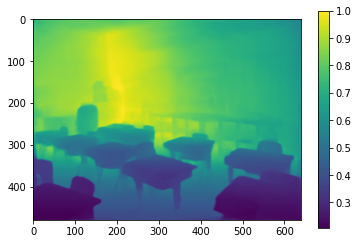

In [ ]:
# Show estimated image
plt.imshow(normalized_image)
plt.colorbar()

Depth Thresholds: **0 - 0.33, 0.33 - 0.66, 0.66 - 1.00**

Close, Medium Distance, Far Away

Going to create these thresholds using `namedtuple` for some Pythonic code.

In [59]:
from collections import namedtuple

Threshold = namedtuple("Threshold", ["lbound", "rbound", "state"])

close_threshold = Threshold(0, 0.33, "Close to {0}. Please move away from the object!")
approach_threshold = Threshold(0.33, 0.66, "Approaching {0}. Be prepared to steer away.")
far_threshold = Threshold(0.66, 1, "Far from {0}.")

### Scaling the Bounding Box For Desired Depth Network

The depth neural network for AdaBins takes images that are of size 640 x 480. So the image bounding boxes must be resized to the given dimensions. The bounding boxes are then saved as CSV Files to be reloaded for AdaBins.

In [44]:
# Reset directory back to home
%cd ../
%ls

/content


In [38]:
DESIRED_WIDTH = 640 # For AdaBins
DESIRED_HEIGHT = 480 # For AdaBins
CONFIDENCE_THRESHOLD = 5 # how many bounding boxes to load at once

bboxes = get_bboxes(model, images)

for i, image in enumerate(images):
  image_cv = Image.open(image)
  width, height = image_cv.width, image_cv.height
  bboxes_current: pd.DataFrame = bboxes[i].head(CONFIDENCE_THRESHOLD)
  bboxes_current = bboxes_current.reset_index()
  for df_index, df_row in bboxes_current.iterrows():
    # resize each of the xmin, ymin, xmax, ymax to match DESIRED WIDTH HEIGHT
    bboxes_current.at[df_index, 'xmin'] = (int(df_row['xmin']) * DESIRED_WIDTH) / width
    bboxes_current.at[df_index, 'xmax'] = (int(df_row['xmax']) * DESIRED_WIDTH) / width
    bboxes_current.at[df_index, 'ymin'] = (int(df_row['ymin']) * DESIRED_HEIGHT) / height
    bboxes_current.at[df_index, 'ymax'] = (int(df_row['ymax']) * DESIRED_HEIGHT) / height
  bboxes_current.to_csv(f"curr_bboxes{i}.csv")

image 1/1: 416x416 2 recycling_bins, 1 trash_bin
Speed: 48.3ms pre-process, 58.4ms inference, 7.8ms NMS per image at shape (1, 3, 640, 640)


Show the bounding boxes unscaled.

image 1/1: 416x416 2 recycling_bins, 1 trash_bin
Speed: 12.0ms pre-process, 24.2ms inference, 2.0ms NMS per image at shape (1, 3, 640, 640)


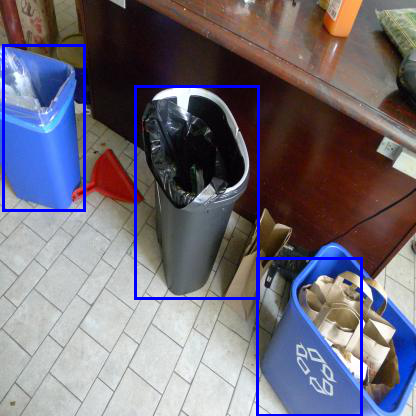

In [37]:
from PIL import ImageDraw

bboxes = get_bboxes(model, images)
color = (0, 0, 255)
thickness = 3
image_rects = []

for i, image in enumerate(images):
  image_cv = Image.open(image)
  image_draw = ImageDraw.Draw(image_cv)
  bboxes_current: pd.DataFrame = bboxes[i]
  bboxes_current = bboxes_current.reset_index()
  for df_index, df_row in bboxes_current.iterrows():
    start_coords = (int(df_row['xmin']), int(df_row['ymin']))
    end_coords = (int(df_row['xmax']), int(df_row['ymax']))
    #image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
    image_draw.rectangle([start_coords, end_coords], outline=color, width=thickness)
  display(image_cv)


### Combine Depth Perception Results With Bounding Boxes

First, we are going to show the bounding boxes on the depth-estimated image.

In [ ]:
for i, image in enumerate(images):
  if exists(f"curr_bboxes{i}.csv"):
    bbox_df = pd.read_csv(f"curr_bboxes{i}.csv")
    
    image_cv = Image.open(image)
    image_cv = image_cv.resize((DESIRED_WIDTH, DESIRED_HEIGHT))
    bin_centers, predicted_depth = infer_helper.predict_pil(image_cv)
    
    depth_image = predicted_depth[0][0]
    image_draw = ImageDraw.Draw(image_cv)
    bboxes_current: pd.DataFrame = bboxes[i]
    bboxes_current = bboxes_current.reset_index()
    
    for df_index, df_row in bboxes_current.iterrows():
      start_coords = (int(df_row['xmin']), int(df_row['ymin']))
      end_coords = (int(df_row['xmax']), int(df_row['ymax']))
      #image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
      image_draw.rectangle([start_coords, end_coords], outline=color, width=thickness)
    display(image_cv)    

And now we do the actual thresholding for depth

1. First, we get the conditionals based on the mean depth value in the image.
2. Then, we state the result based on the depth value



In [ ]:
# Function to state the depth based on class and average depth value 
def state_depth(avg_depth, class_type):
  print('-' * 50)
  if close_threshold.lbound <= avg_depth and avg_depth < close_threshold.rbound:
    print(close_threshold.state.format(class_type))
  elif approach_threshold.lbound <= avg_depth and avg_depth < approach_threshold.rbound:
    print(approach_threshold.state.format(class_type))
  else:
    print(far_threshold.state.format(class_type))
  print('-' * 50)

''' 
In reality, this would include haptic feedback but this is the best I can do in 
a Colab notebook. Perhaps, I can be a bit more specific given where the object is 
in the image but this is a good prototype.
'''

State the result for each image

In [ ]:
for i, image in enumerate(images):
  if exists(f"curr_bboxes{i}.csv"):
    bbox_df = pd.read_csv(f"curr_bboxes{i}.csv")
    
    image_cv = Image.open(image)
    image_cv = image_cv.resize((DESIRED_WIDTH, DESIRED_HEIGHT))
    bin_centers, predicted_depth = infer_helper.predict_pil(image_cv)
    
    depth_image_norm = normalize(predicted_depth[0][0]) # this is a numpy array

    # Index numpy array for all bounding boxes
    for df_index, df_row in bbox_df.iterrows():
      xmin, xmax = int(df_row['xmin']), int(df_row['xmax'])
      ymin, ymax = int(df_row['ymin']), int(df_row['ymax'])
      np_bbox = depth_image_norm[xmin:xmax, ymin:ymax]

      bbox_mean_depth = np.mean(np_bbox)
      state_depth(bbox_mean_depth, df_row['name'])

##Done with the initial prototype!